# Лабораторна робота №3


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Завдання перше: 1. Повнозв'язані нейронні мережі  
Візьміть дані, з якими ви працювали в лабораторній №1.  Побудуйте повнозв’язану нейронну мережу
прямого поширення для задачі класифікації.
Навчіть її на тренувальній вибірці, протестуйте на тестовій. Порівняйте результати з алгоритмами з Lab 1

In [6]:
file_path = "academic Stress level - maintainance 1.csv"
df = pd.read_csv(file_path)
selected_columns = df.iloc[:, [2, 3, 7, 8]].copy()
df_clean = selected_columns.fillna(selected_columns.median())

In [7]:
X = df_clean.iloc[:, :-1].values
y = df_clean.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=101, stratify=y
)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train - 1) 
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test - 1)

In [9]:
class StressClassifierNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StressClassifierNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2) # Для зменшення перенавчання
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

In [11]:
input_dim = X_train.shape[1] 
output_dim = 5               
model = StressClassifierNN(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

починаємо тренування моделі: 


In [12]:
epochs = 300
loss_history = []

model.train()
for epoch in range(epochs):

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [50/300], Loss: 1.0176
Epoch [100/300], Loss: 0.9443
Epoch [150/300], Loss: 0.8526
Epoch [200/300], Loss: 0.8091
Epoch [250/300], Loss: 0.7615
Epoch [300/300], Loss: 0.6720


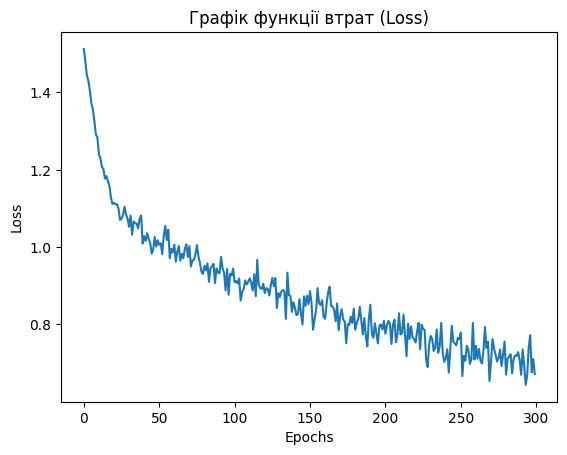

In [13]:

plt.plot(loss_history)
plt.title('Графік функції втрат (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
model.eval() 
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    
    y_pred_numpy = predicted.numpy() + 1
    y_true_numpy = y_test_tensor.numpy() + 1

accuracy = accuracy_score(y_true_numpy, y_pred_numpy)
print(f"\nAccuracy (Neural Network): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_true_numpy, y_pred_numpy, zero_division=0))


Accuracy (Neural Network): 0.3810

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.33      0.18      0.24        11
           4       0.38      0.59      0.47        17
           5       0.44      0.40      0.42        10

    accuracy                           0.38        42
   macro avg       0.23      0.23      0.22        42
weighted avg       0.35      0.38      0.35        42



Як ми бачимо macro avg тут 0.22, в той час як у першій лабораторній роботі:  
KNeighbors має 0.28,  
DecisionTree має 0.20,  
SVM(з жадібним пошуком) має 0.17,   
RandomForest має 0.38,   
і AdaBoost має 0.25.   
Легко бачити, що краща точність мається в RandomForest. 